#### Ribo-Seq validation

In this notebook we use data from published ribosome profiling studies to derive another measure of ribosome loading and we check to what extent our model can predict it from the 5utr sequence

In [15]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import load_model
from sklearn.linear_model import LinearRegression

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

pd.options.mode.chained_assignment = None 

### Importing the data and model

In [2]:
with open("../Data/ribo_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)
    
andreev_df = data_dict["andreev"]
pcr3_df = data_dict["pcr3"]
eichhorn_df = data_dict["eichhorn"]

In [3]:
new_model = load_model("../Models/basic_model_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Prepare the data

The andreev dataset comes from the paper "Translation of 5′ leaders is pervasive in genes resistant to eIF2 repression" (Andreev et al) and represents ribosome profiling data of HEK293 cells.
The pcr3 dataset is from the paper "Genome-wide assessment of differential translations with ribosome profiling data" (Xiao et al) and represents ribosome profiling data of PCR3 cells. 
The eichhorn dataset is from "mRNA Destabilization Is the Dominant Effect of Mammalian MicroRNAs by the Time Substantial Repression Ensues" (Eichhorn et al) and represents ribosome profiling of HEK293 cells.
In all cases we are only interested in the control condition and compute the "ribosome load" by dividing (normalized) RPF counts by RNA-seq counts and taking a logarithm

In [4]:
## Subsetting
andreev_df_sub = andreev_df[(
andreev_df["rpf"] > 10) & (andreev_df["rnaseq_norm"] > 100)]
pcr3_df_sub = pcr3_df[(pcr3_df["control1(RPF)_normalized"] > 10) & (pcr3_df["control1(mRNA)_normalized"] > 100)]

In [5]:
## Computing the load
andreev_df_sub["log_load"] = np.log(andreev_df_sub["rpf"]/andreev_df_sub["rnaseq_norm"])
pcr3_df_sub["log_load_control_1"] = np.log(pcr3_df_sub["control1(RPF)_normalized"]/pcr3_df_sub["control1(mRNA)_normalized"])
pcr3_df_sub["log_load_control_2"] = np.log(pcr3_df_sub["control2(RPF)_normalized"]/pcr3_df_sub["control2(mRNA)_normalized"])
eichhorn_df["log_load"] = np.log(eichhorn_df["RPF_RPKM"]/eichhorn_df["RNA_RPKM"])

In [7]:
## Encoding the sequences
andreev_df_sub["library"] = "egfp_unmod_1"
andreev_encoded = utils.encode_df(andreev_df_sub, col="utr", output_col=None, variable_len=True)

pcr3_df_sub["library"] = "egfp_unmod_1"
pcr3_encoded = utils.encode_df(pcr3_df_sub, col="utr", output_col=None, variable_len=True)

eichhorn_df["library"] = "egfp_unmod_1"
eichhorn_encoded = utils.encode_df(eichhorn_df, col="utr", output_col=None, variable_len=True)

Pearson: 0.917, p-val: 0.000, squared: 0.840, Spearman: 0.915, p-val: 0.000


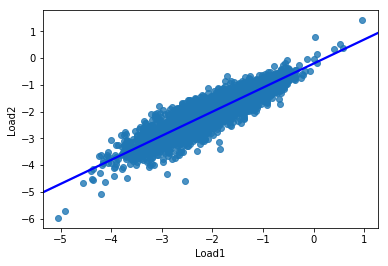

In [36]:
df = pd.DataFrame({"Load1": pcr3_df_sub["log_load_control_1"], "Load2":pcr3_df_sub["log_load_control_2"]})
x = sns.regplot(x='Load1', y="Load2", data=df, line_kws={"color":"b"}).get_figure()
utils.print_corrs(pcr3_df_sub["log_load_control_2"], pcr3_df_sub["log_load_control_1"])

Pearson: 0.604, p-val: 0.000, squared: 0.364, Spearman: 0.591, p-val: 0.000


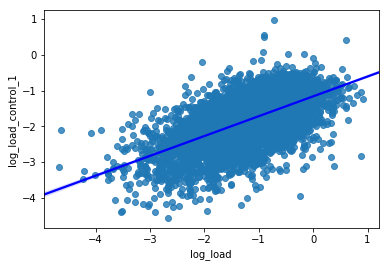

In [46]:
df = andreev_df_sub.merge(pcr3_df_sub, on = "GeneName")
x = sns.regplot(x='log_load', y="log_load_control_1", data=df, line_kws={"color":"b"}).get_figure()
utils.print_corrs(df["log_load"], df["log_load_control_1"])

Pearson: 0.555, p-val: 0.000, squared: 0.308, Spearman: 0.522, p-val: 0.000


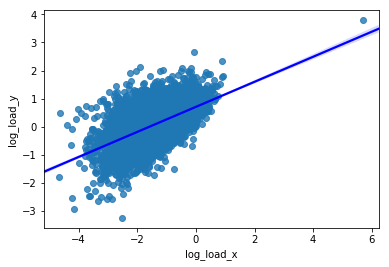

In [59]:
df = andreev_df_sub.merge(eichhorn_df, on = "GeneName")
x = sns.regplot(x='log_load_x', y="log_load_y", data=df, line_kws={"color":"b"}).get_figure()
utils.print_corrs(df["log_load_x"], df["log_load_y"])

### Predict

In [9]:
predictions_andreev = new_model.predict([andreev_encoded["seq"], andreev_encoded["library"]])
predictions_pcr3 = new_model.predict([pcr3_encoded["seq"], pcr3_encoded["library"]])
predictions_eichhorn = new_model.predict([eichhorn_encoded["seq"], eichhorn_encoded["library"]])

### Evaluate

In [62]:
utils.print_corrs(predictions_andreev.reshape(-1), andreev_df_sub["log_load"])
utils.print_corrs(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_1"])
utils.print_corrs(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_2"])
utils.print_corrs(predictions_eichhorn.reshape(-1), eichhorn_df["log_load"])

Pearson: 0.230, p-val: 0.000, squared: 0.053, Spearman: 0.235, p-val: 0.000
Pearson: 0.252, p-val: 0.000, squared: 0.064, Spearman: 0.256, p-val: 0.000
Pearson: 0.239, p-val: 0.000, squared: 0.057, Spearman: 0.244, p-val: 0.000
Pearson: 0.214, p-val: 0.000, squared: 0.046, Spearman: 0.212, p-val: 0.000


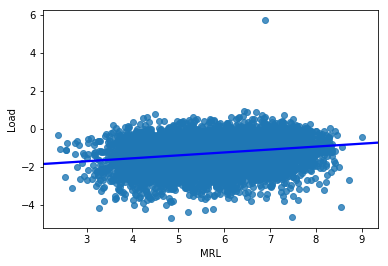

In [93]:
df = pd.DataFrame({"MRL":predictions_andreev.reshape(-1), "Load":andreev_df_sub["log_load"]})
x = sns.regplot(x='MRL', y="Load", data=df, line_kws={"color":"b"}).get_figure()

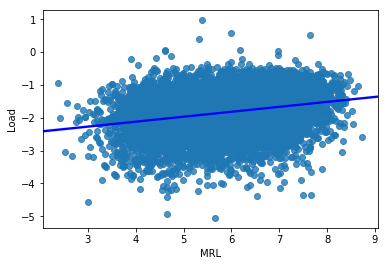

In [94]:
df = pd.DataFrame({"MRL":predictions_pcr3.reshape(-1), "Load":pcr3_df_sub["log_load_control_1"]})
x = sns.regplot(x='MRL', y="Load", data=df, line_kws={"color":"b"}).get_figure()

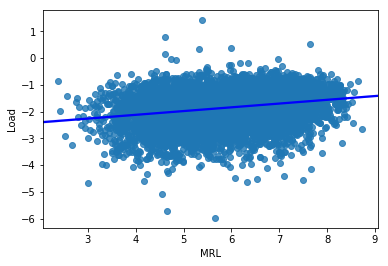

In [95]:
df = pd.DataFrame({"MRL":predictions_pcr3.reshape(-1), "Load":pcr3_df_sub["log_load_control_2"]})
x = sns.regplot(x='MRL', y="Load", data=df, line_kws={"color":"b"}).get_figure()

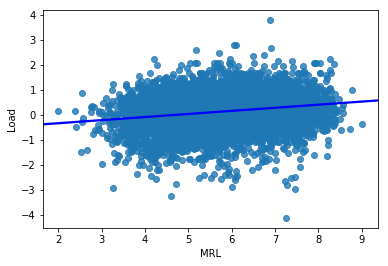

In [75]:
df = pd.DataFrame({"MRL":predictions_eichhorn.reshape(-1), "Load":eichhorn_df["log_load"]})
x = sns.regplot(x='MRL', y="Load", data=df, line_kws={"color":"b"}).get_figure()

In each case the pearson r-squared hovers around 5%. This shows that the model does capture some notion of translation efficiency. It should be noted that the model only looks at the 5utr. While this contributes to ribosome load, the load as measured in an ribo-seq experiment will be heavily impacted by such factors as codon-efficiency, overall gene length and also the 3utr.

### Compute r-squared for baseline fixed length model

In [65]:
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")

In [66]:
andreev_df_sub_50 = andreev_df_sub.copy()
andreev_df_sub_50["utr"] = andreev_df_sub["utr"].str[-50:]
andreev_encoded_sub_50 = utils.encode_df(andreev_df_sub_50, col="utr", output_col=None, variable_len=True)

pcr3_df_sub_50 = pcr3_df_sub.copy()
pcr3_df_sub_50["utr"] = pcr3_df_sub["utr"].str[-50:]
pcr3_encoded_sub_50 = utils.encode_df(pcr3_df_sub_50, col="utr", output_col=None, variable_len=True)

In [67]:
eichhorn_df_sub_50 = eichhorn_df.copy()
eichhorn_df_sub_50["utr"] = eichhorn_df_sub_50["utr"].str[-50:]
eichhorn_encoded_sub_50 = utils.encode_df(eichhorn_df_sub_50, col="utr", output_col=None, variable_len=True)

In [68]:
predictions_andreev = paper_model.predict(andreev_encoded_sub_50["seq"])
predictions_pcr3 = paper_model.predict(pcr3_encoded_sub_50["seq"])

In [69]:
predictions_eichhorn = paper_model.predict(eichhorn_encoded_sub_50["seq"])

In [70]:
utils.print_corrs(predictions_andreev.reshape(-1), andreev_df_sub["log_load"])
utils.print_corrs(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_1"])
utils.print_corrs(predictions_pcr3.reshape(-1), pcr3_df_sub["log_load_control_2"])
utils.print_corrs(predictions_eichhorn.reshape(-1), eichhorn_df["log_load"])

Pearson: 0.165, p-val: 0.000, squared: 0.027, Spearman: 0.146, p-val: 0.000
Pearson: 0.229, p-val: 0.000, squared: 0.052, Spearman: 0.213, p-val: 0.000
Pearson: 0.218, p-val: 0.000, squared: 0.047, Spearman: 0.204, p-val: 0.000
Pearson: 0.091, p-val: 0.000, squared: 0.008, Spearman: 0.064, p-val: 0.000


While the fixed-size model still does comparatively well, it does consistently perform worse than its size flexible counterpart (which is unsurprising, given that it will miss any motive more than 50 nucleotides from the canonical start)

### Checking if adding (canonical) TIS strength improves results

In [10]:
noderer_score = utils.build_tis_score_dict(replace_u=False)

In [11]:
andreev_df_sub = utils.extract_tis(andreev_df_sub)
pcr3_df_sub = utils.extract_tis(pcr3_df_sub)
eichhorn_df = utils.extract_tis(eichhorn_df)

In [12]:
andreev_df_sub["score"] = [noderer_score[tis] for tis in andreev_df_sub["tis"]]
pcr3_df_sub["score"] = [noderer_score[tis] for tis in pcr3_df_sub["tis"]]
eichhorn_df["score"] = [noderer_score[tis] for tis in eichhorn_df["tis"]]

In [16]:
X = np.concatenate([predictions_andreev, np.array(andreev_df_sub["score"])[:, np.newaxis]], axis=1)
y = np.array(andreev_df_sub["log_load"])[:, np.newaxis]
# without
reg = LinearRegression().fit(X[:,0:1], y)
print("without: " + str(reg.score(X[:,0:1], y)))
#with
reg = LinearRegression().fit(X, y)
y_hat = reg.predict(X)
print("with tis score: " + str(utils.adjust_r2(utils.rSquared(y_hat.reshape(-1), y.reshape(-1)), X.shape[0], X.shape[1])))

without: 0.05269553724444942
with tis score: 0.054061290228597736


In [17]:
X = np.concatenate([predictions_eichhorn, np.array(eichhorn_df["score"])[:, np.newaxis]], axis=1)
y = np.array(eichhorn_df["log_load"])[:, np.newaxis]
# without
reg = LinearRegression().fit(X[:,0:1], y)
print("without: " + str(reg.score(X[:,0:1], y)))
#with
reg = LinearRegression().fit(X, y)
y_hat = reg.predict(X)
print("with tis score: " + str(utils.adjust_r2(utils.rSquared(y_hat.reshape(-1), y.reshape(-1)), X.shape[0], X.shape[1])))

without: 0.04570454759976129
with tis score: 0.04590259095583704
